In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os
import cv2
from tqdm import tqdm
import random

In [29]:
DATASET_PATH = "/kaggle/input/gtsrb-german-traffic-sign"
IMG_SIZE = 32  
NUM_CLASSES = 43
EPOCHS = 20
BATCH_SIZE = 64

In [3]:
train_df = pd.read_csv(os.path.join(DATASET_PATH, "Train.csv"))
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [4]:
# Label Mapping
classes = { 
    0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)', 
    4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 
    8: 'Speed limit (120km/h)', 9: 'No passing', 10: 'No passing veh over 3.5 tons', 11: 'Right-of-way at intersection', 
    12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles', 16: 'Veh > 3.5 tons prohibited', 17: 'No entry', 
    18: 'General caution', 19: 'Dangerous curve left', 20: 'Dangerous curve right', 21: 'Double curve', 22: 'Bumpy road', 
    23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work', 26: 'Traffic signals', 27: 'Pedestrians', 
    28: 'Children crossing', 29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing', 
    32: 'End speed + passing limits', 33: 'Turn right ahead', 34: 'Turn left ahead', 35: 'Ahead only', 
    36: 'Go straight or right', 37: 'Go straight or left', 38: 'Keep right', 39: 'Keep left', 
    40: 'Roundabout mandatory', 41: 'End of no passing', 42: 'End no passing veh > 3.5 tons'
}


In [5]:
X, y = [], []

# Load images
for i in tqdm(range(len(train_df))):
    img_path = os.path.join(DATASET_PATH, train_df.loc[i, "Path"])  

    if not os.path.exists(img_path):
        print(f" Missing file: {img_path}")
        continue

    image = cv2.imread(img_path)
    if image is None:
        print(f" Corrupted file: {img_path}")
        continue

    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))  
    X.append(image)
    y.append(train_df.loc[i, "ClassId"])

print(f" Successfully loaded {len(X)} images!")

100%|██████████| 39209/39209 [03:12<00:00, 203.63it/s]

 Successfully loaded 39209 images!


In [6]:
X = np.array(X) / 255.0  
y = to_categorical(np.array(y), NUM_CLASSES)  

In [7]:
y_original = np.array([train_df.loc[i, "ClassId"] for i in range(len(train_df))])  

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_original)


print(f" Loaded {len(X_train)} training and {len(X_val)} validation images!")

 Loaded 31367 training and 7842 validation images!


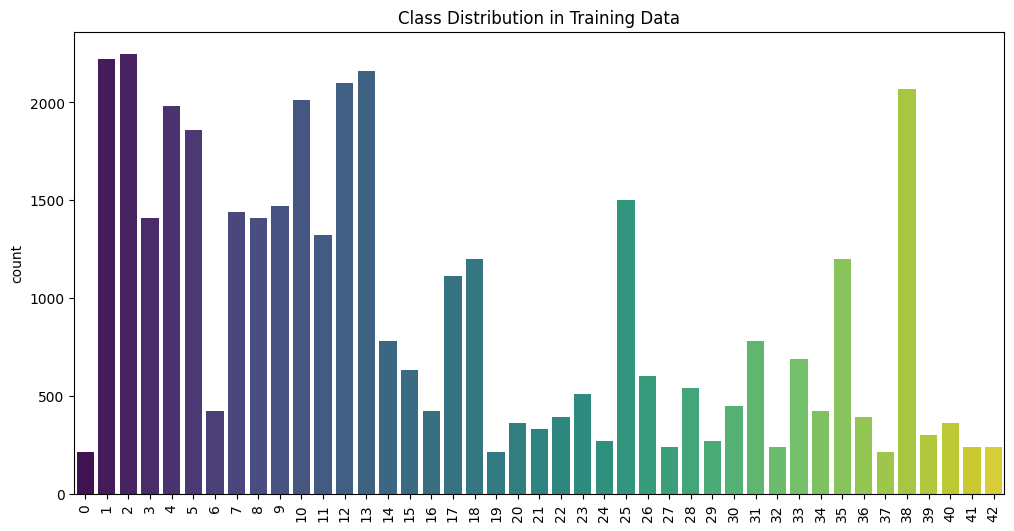

In [8]:
import seaborn as sns
y_labels = np.argmax(y, axis=1)

plt.figure(figsize=(12, 6))
sns.countplot(x=y_labels, palette="viridis")
plt.xticks(rotation=90)
plt.title("Class Distribution in Training Data")
plt.show()


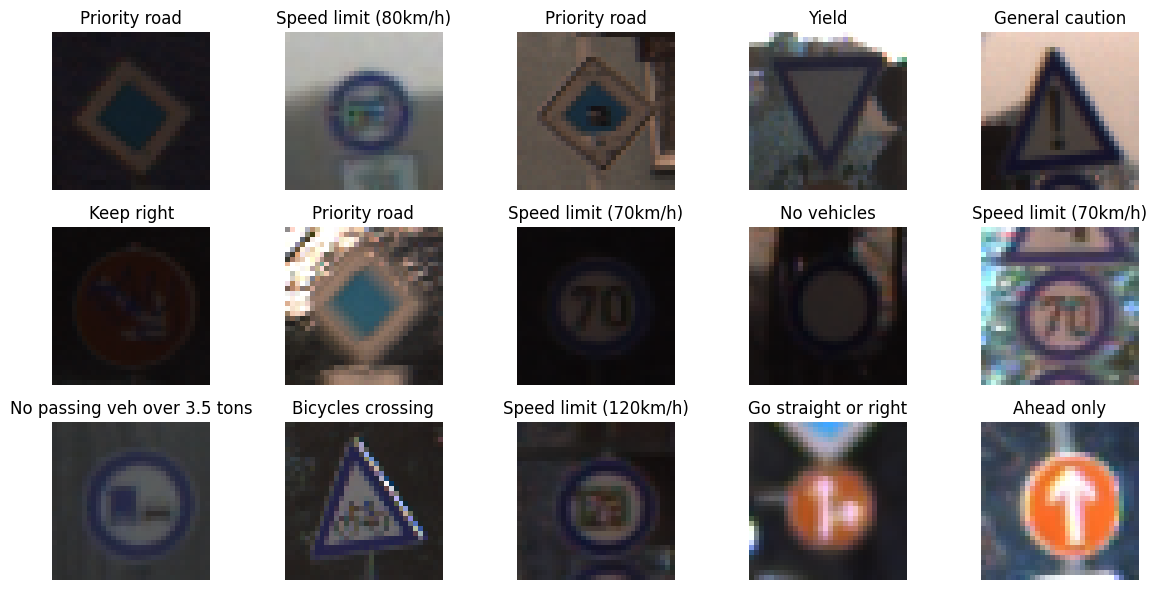

In [9]:
plt.figure(figsize=(12, 6))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(X_train[i])
    plt.title(classes[np.argmax(y_train[i])]) 
    plt.axis("off")
plt.tight_layout()
plt.show()


In [10]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')  
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │           5,547 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 319,979 (1.22 MB)

 Trainable params: 319,979 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
history = model.fit(
    X_train, y_train,  
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,  
    verbose=1
)



Epoch 1/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3464 - loss: 2.4384 - val_accuracy: 0.8859 - val_loss: 0.4004
Epoch 2/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8175 - loss: 0.5834 - val_accuracy: 0.9686 - val_loss: 0.1563
Epoch 3/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8935 - loss: 0.3395 - val_accuracy: 0.9758 - val_loss: 0.0938
Epoch 4/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9196 - loss: 0.2506 - val_accuracy: 0.9870 - val_loss: 0.0679
Epoch 5/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9372 - loss: 0.1926 - val_accuracy: 0.9887 - val_loss: 0.0561
Epoch 6/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9463 - loss: 0.1628 - val_accuracy: 0.9890 - val_loss: 0.0457
Epoch 7/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9531 - loss: 0.1440 - val_accuracy: 0.9911 - val_loss: 0.0407
Epoch 8/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9597 - loss: 0.1268 - val_accuracy: 0.

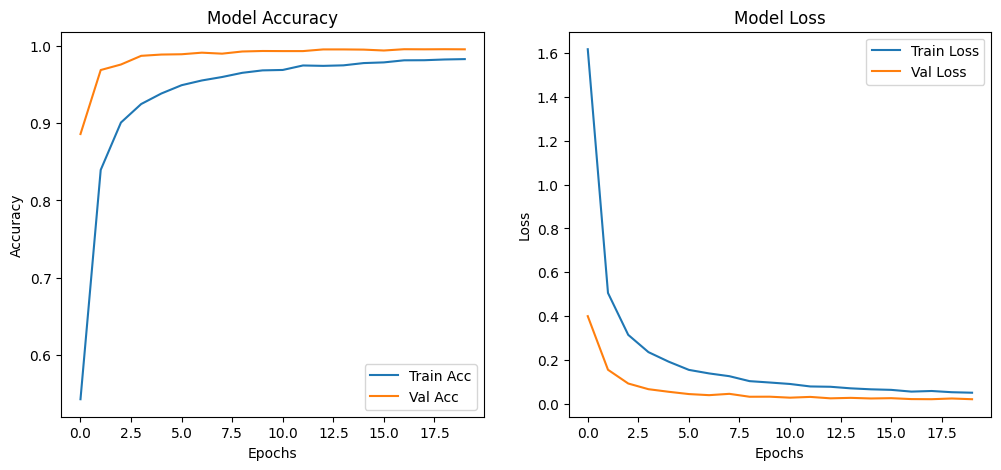

In [13]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [14]:
test_df = pd.read_csv(os.path.join(DATASET_PATH, "Test.csv"))

X_test, y_test = [], []
for i in tqdm(range(len(test_df))):
    img_path = os.path.join(DATASET_PATH, test_df.loc[i, "Path"])
    image = cv2.imread(img_path)
    
    if image is None:
        print(f" Skipping corrupted file: {img_path}")
        continue

    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    X_test.append(image)
    y_test.append(test_df.loc[i, "ClassId"])

100%|██████████| 12630/12630 [00:46<00:00, 272.35it/s]


In [15]:

X_test = np.array(X_test) / 255.0
y_test = to_categorical(np.array(y_test), NUM_CLASSES)

In [16]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9704 - loss: 0.1515
Test Accuracy: 96.81%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


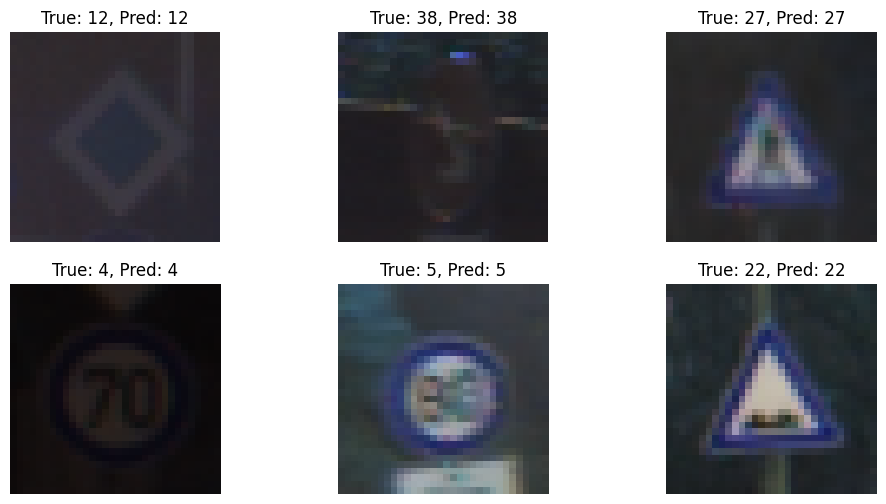

In [17]:
# Visualize Predictions
def plot_predictions(model, X, y, num_samples=6):
    plt.figure(figsize=(12, 6))
    indices = random.sample(range(len(X)), num_samples)
    for i, idx in enumerate(indices):
        img = X[idx]
        true_label = np.argmax(y[idx])
        pred_label = np.argmax(model.predict(img.reshape(1, IMG_SIZE, IMG_SIZE, 3)))
        
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f"True: {true_label}, Pred: {pred_label}")
        plt.axis("off")
    plt.show()

plot_predictions(model, X_test, y_test)

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


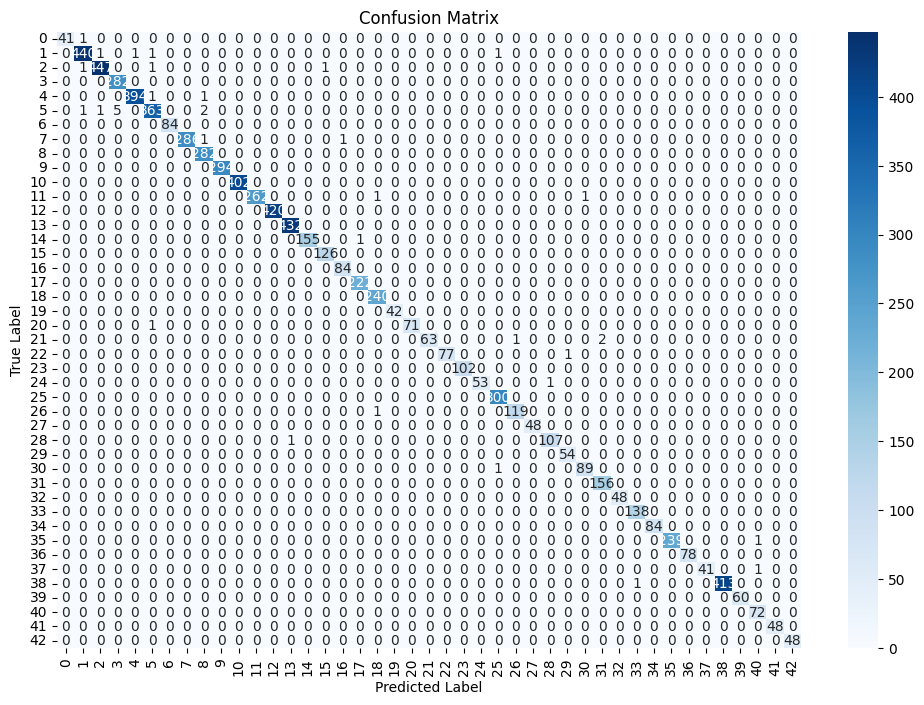

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions
y_pred = np.argmax(model.predict(X_val), axis=1)

# Convert y_val back from one-hot encoding to class labels
y_true = np.argmax(y_val, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [19]:
from sklearn.metrics import classification_report

# Convert y_val from one-hot encoding to class labels
y_true = np.argmax(y_val, axis=1)

# Print classification report
print(classification_report(y_true, y_pred, target_names=[classes[i] for i in range(43)]))



                               precision    recall  f1-score   support

         Speed limit (20km/h)       1.00      0.98      0.99        42
         Speed limit (30km/h)       0.99      0.99      0.99       444
         Speed limit (50km/h)       1.00      0.99      0.99       450
         Speed limit (60km/h)       0.98      1.00      0.99       282
         Speed limit (70km/h)       1.00      0.99      1.00       396
         Speed limit (80km/h)       0.99      0.98      0.98       372
  End of speed limit (80km/h)       1.00      1.00      1.00        84
        Speed limit (100km/h)       1.00      0.99      1.00       288
        Speed limit (120km/h)       0.99      1.00      0.99       282
                   No passing       1.00      1.00      1.00       294
 No passing veh over 3.5 tons       1.00      1.00      1.00       402
 Right-of-way at intersection       1.00      0.99      1.00       264
                Priority road       1.00      1.00      1.00       420
     

In [34]:
image_path = "/kaggle/input/newsign/ylde.jpg"
image = cv2.imread(image_path)

image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

image = image / 255.0  

image = np.expand_dims(image, axis=0)
prediction = model.predict(image)

predicted_class = np.argmax(prediction)

predicted_label = classes[predicted_class]

print(f"Predicted Traffic Sign: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Traffic Sign: Yield


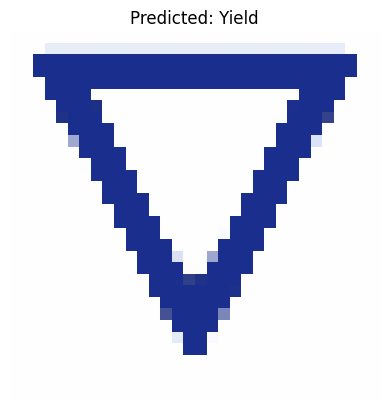

In [36]:
import matplotlib.pyplot as plt

image = cv2.imread(image_path)
image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.title(f"Predicted: {predicted_label}")
plt.axis("off")
plt.show()

In [37]:
image_path = "/kaggle/input/signs4/cau.jpg"
image = cv2.imread(image_path)

image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

image = image / 255.0  

image = np.expand_dims(image, axis=0)
prediction = model.predict(image)

predicted_class = np.argmax(prediction)

predicted_label = classes[predicted_class]

print(f"Predicted Traffic Sign: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Traffic Sign: General caution


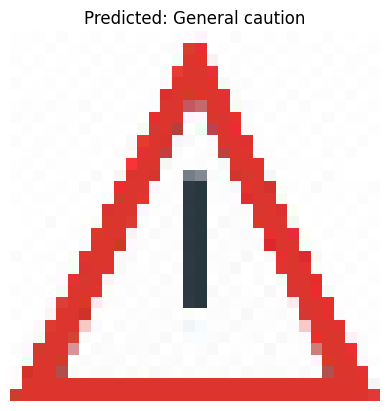

In [38]:
image = cv2.imread(image_path)
image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.title(f"Predicted: {predicted_label}")
plt.axis("off")
plt.show()

In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model
with open("traffic_sign_classifier.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpf4mmv3cs'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 43), dtype=tf.float32, name=None)
Captures:
  138913150758304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138912826343488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138912826352464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138912826349472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138912826351056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138912826353344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138912826352992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138912826354928: TensorSpec(shape=(), dtype=tf.resource, name=None)
